In [1]:
# Basic Imports
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from functools import partial

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
# import torch.utils.data as data
# from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets import MNIST
import torch
import torch.nn as tnn

# JAX/Flax
import jax
from jax import jit
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
import optax
import orbax.checkpoint
from flax.training import train_state, orbax_utils
import wandb

## Create a dataset of 2 Gaussians

$p_{data} = 0.5 \mathcal{N}(\mu_1, \sigma I) + 0.5 \mathcal{N}(-\mu_1, \sigma I)$

In [2]:
key = random.PRNGKey(0)
rng, subkey1, subkey2 = random.split(key, num=3)

(2000, 10)


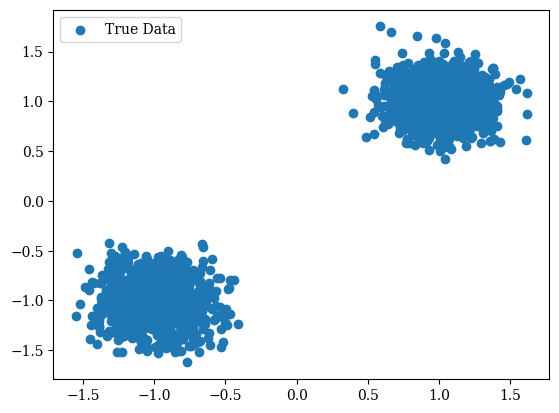

In [3]:
size = 1000 # N
std = 0.2
mean_scale = 1

# Generate data for X_0 & X_1
X_0 = mean_scale + random.normal(subkey1, shape=(size, 10)) * std
X_1 = -mean_scale + random.normal(subkey2, shape=(size, 10)) * std

# Concantenate
X = jnp.concatenate([X_0, X_1], axis=0)
print(X.shape)

# Visuaize
plt.scatter(X[:, 0], X[:, 1], label='True Data')
plt.legend()
plt.show()

## Construct data loader

In [4]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return np.array(self.X[idx])

def numpy_collate(batch):
    """
    Function to allow jnp.arrays to be used in PyTorch Dataloaders.
    """
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    
class NumpyLoader(torch.utils.data.DataLoader):
    """
    Custom PyTorch DataLoader for numpy/JAX arrays
    """
    def __init__(self, dataset, batch_size=1,
                 shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0,
                 pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             sampler=sampler,
                                             batch_sampler=batch_sampler,
                                             num_workers=num_workers,
                                             collate_fn=numpy_collate,
                                             pin_memory=pin_memory,
                                             drop_last=drop_last,
                                             timeout=timeout,
                                             worker_init_fn=worker_init_fn)
    
train_dataset = JaxDataset(X=X)
train_loader = NumpyLoader(dataset=train_dataset, batch_size=128, shuffle=False)
train_loader_torch = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=False, collate_fn=numpy_collate)

In [5]:
batch = next(iter(train_loader))
batch_torch = next(iter(train_loader_torch))
print(np.allclose(batch, batch_torch))

True


## Construct NN

$$\text{P}(k, 2i) = \text{sin}\Big(\frac{k}{n^{2i/d}} \Big)$$
$$\text{P}(k, 2i+1) = \text{cos}\Big(\frac{k}{n^{2i/d}} \Big)$$

See [this](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/#:~:text=What%20Is%20Positional%20Encoding%3F,item's%20position%20in%20transformer%20models.) article about positional encoding.

In [6]:
def getPositionEncoding(t: List[int], d: int, n: int = 10000) -> np.ndarray:
    """
    Generate the positional encoding for given positions 't' and dimension 'd'.
    The encoding has sine values at even indices and cosine values at odd indices.

    Args:
    -----
        t: List[int]
            List of positions for which the encoding is to be generated.
        d: int
            Dimension of the encoding vector for each position.
        n: int
            The base of the denominator in the encoding formula. Default value is 10000.

    Returns:
    --------
        P: np.ndarray
            A 2D numpy array with shape (len(t), d) representing the positional encoding.
    """
    # Determine the number of positions
    seq_len = len(t)
    # Initialize the encoding matrix with zeros
    P = np.zeros((seq_len, d))
    # For each position in t
    for k_idx, k in enumerate(t):
        # For each dimension up to d/2
        for i in np.arange(int(d/2)):
            # Calculate the denominator for this dimension
            denominator = np.power(n, 2*i/d)
            # Calculate the sine and cosine encoding for this position and dimension
            P[k_idx, 2*i] = np.sin(k/denominator)
            P[k_idx, 2*i+1] = np.cos(k/denominator)
    
    return P        

In [36]:
class ScoreNet(nn.Module):
    """
    Common architecture for score-based generative models,
    """
    dim: int = 10  # Change from 2 to 10 to match input size
    latent_dim: int = 32
    std_data: float = 0.5
    
    @nn.compact
    def __call__(self, x, t):
        t = t.squeeze()  # Ensure t is scalar if it's not
        c_out = t * self.std_data / np.sqrt(self.std_data**2 + t**2)
        c_skip = self.std_data**2 / (self.std_data**2 + t**2)

        t = np.log(t.flatten()) / 4.
        
        x_1 = nn.Dense(self.latent_dim)(x) + getPositionEncoding(t, d=self.latent_dim)
        x_2 = nn.relu(x_1)
        x_3 = nn.relu(nn.Dense(self.latent_dim)(x_2) + nn.Dense(self.latent_dim)(x_1))
        x_4 = nn.relu(nn.Dense(self.latent_dim)(x_3)) + nn.Dense(self.latent_dim)(x)
        x_5 = nn.Dense(self.dim)(x_4)  # Now output is of size 10
        
        # Reshape c_out and c_skip to match dimensions for broadcasting
        c_out = np.reshape(c_out, (-1, 1))
        c_skip = np.reshape(c_skip, (-1, 1))
        
        return c_out * x_5 + c_skip * x

model = ScoreNet(dim=10, latent_dim=32, std_data=0.5)  # Change dim to 10

rnd_normal = random.normal(subkey1, shape=(batch.shape[0], 1))
t = np.exp(rnd_normal * 1.2 - 1.2)
print(model.tabulate(jax.random.PRNGKey(9), batch, t))


                                ScoreNet Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs            ┃ outputs         ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ ScoreNet │ - float32[128,10] │ float32[128,10] │                   │
│         │          │ - float32[128,1]  │                 │                   │
├─────────┼──────────┼───────────────────┼─────────────────┼───────────────────┤
│ Dense_0 │ Dense    │ float32[128,10]   │ float32[128,32] │ bias: float32[32] │
│         │          │                   │                 │ kernel:           │
│         │          │                   │                 │ float32[10,32]    │
│         │          │                   │                 │                   │
│         │          │                   │                 │ 352 (1.4 KB)      │
├─────────┼──────────┼─────

## Training Loop

**Algorithm 2:** PFGM++ training with hyperparameter transferred from EDM

**Input:**

- $\sigma(t)$ = `t`
- $r = \sigma\sqrt{D}$
- Noise distribution: $\text{ln}(\sigma) \sim \mathcal{N}(P_{mean}, P_{std}^2) = \mathcal{N}(-1.2, 1.2^2) \rightarrow \sigma \sim \text{exp}(\mathcal{N}(-1.2, 1.2^2))$
- Loss weighting: $\lambda(\sigma) = \frac{(\sigma^2 + \sigma^2_{data})}{(\sigma \cdot \sigma_{data})^2} = \frac{(t^2 + \sigma^2_{data})}{(t \cdot \sigma_{data})^2}$
$$f_\theta(\mathbf{x}, \sigma) = \frac{c_{skip}(\sigma)\mathbf{x} + c_{out}(\sigma)F_\theta\big(c_{in}(\sigma)\mathbf{x}, c_{noise}(\sigma)\big) - x}{\sigma} \approx \sigma \nabla_x \text{log}p_\sigma(x)$$

- $$f_\theta(\tilde{\mathbf{x}}) = \frac{c_{skip}(r/\sqrt{D})\mathbf{x} + c_{out}(r/\sqrt{D})F_\theta\big(c_{in}(r/\sqrt{D})\mathbf{x}, c_{noise}(r/\sqrt{D})\big) - x}{r/\sqrt{D}} \approx \sqrt{D} \frac{E(\tilde{\mathbf{x}})_x}{E(\tilde{\mathbf{x}})_r}$$

    - $F_\theta$ = NN 
    - $c_{in}(\sigma) = \frac{1}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{out}(\sigma) = \frac{\sigma \cdot \sigma_{data}}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{skip}(\sigma) = \frac{\sigma_{data}^2}{\sigma^2 + \sigma^2_{data}}$
    - $c_{in}(\sigma) = \frac{1}{4}\text{ln}(\sigma)$ 
    - $\sigma_{data} = 0.5$
- $$ r_i = \big(r_{max}^{1/\rho} + \frac{i}{N-1}(r_{min}^{1/\rho} - r_{max}^{1/\rho})\big)^\rho \hspace{0.2in} \text{ where } \hspace{0.2in} r_N = 0$$
    
    
    
**Pseudocode:**

1. Sample a batch of data $\{\mathbf{y}_i\}^\mathcal{B}_{i=1}$ from $p(\mathbf{y})$
2. Sample standard deviations $\{\sigma_i \}^\mathcal{B}_{i=1}$ from $p(\sigma)$
3. Sample $r$ from $p_r$: $\{r_i = \sigma_i(R)\}^\mathcal{B}_{i=1}$
4. Samples radiuses $\{R_i \sim p_{r_i}(R) \}^\mathcal{B}_{i=1}$
5. Sample uniform angles $\{\mathbf{v}_i = \frac{\mathbf{u}_i}{|| \mathbf{u}_i ||_2} \}^\mathcal{B}_{i=1}$, with $\mathbf{u}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
6. Get perturbed data $\{\hat{\mathbf{y}}_i = \mathbf{y}_i + R_i \mathbf{v}_i \}^\mathcal{B}_{i=1}$
7. Calculate loss $\ell(\theta) = \sum^\mathcal{B}_{i=1} \lambda(\sigma_i)||f_\theta(\hat{\mathbf{y}}_i, \sigma_i) - \mathbf{y}_i||_2^2$
8. Update the network parameter $\theta$ via Adam optimizer


In [ ]:
# Create TrainState
def init_train_state(model: Any,
                     random_key: Any,
                     shape: tuple,
                     learning_rate: int) -> train_state.TrainStatee

In [ ]:
params = {'lr': 1e-3, 'latent_dim': 32}
data_dim = 1000



model = ScoreNet(dim=data_dima, latent_dim=params['latent_dim'], std_data=0.5)  


# Sampling Loop

**Algorithm 4:** PFGM++ sampling with hyperparameter transferred from EDM

**Input:**

- $\sigma(t)$ = `t`
- $r = \sigma\sqrt{D}$
- Noise distribution: $\text{ln}(\sigma) \sim \mathcal{N}(P_{mean}, P_{std}^2) = \mathcal{N}(-1.2, 1.2^2) \rightarrow \sigma \sim \text{exp}(\mathcal{N}(-1.2, 1.2^2))$
- Loss weighting: $\lambda(\sigma) = \frac{(\sigma^2 + \sigma^2_{data})}{(\sigma \cdot \sigma_{data})^2} = \frac{(t^2 + \sigma^2_{data})}{(t \cdot \sigma_{data})^2}$
$$f_\theta(\mathbf{x}, \sigma) = \frac{c_{skip}(\sigma)\mathbf{x} + c_{out}(\sigma)F_\theta\big(c_{in}(\sigma)\mathbf{x}, c_{noise}(\sigma)\big) - x}{\sigma} \approx \sigma \nabla_x \text{log}p_\sigma(x)$$

- $$f_\theta(\tilde{\mathbf{x}}) = \frac{c_{skip}(r/\sqrt{D})\mathbf{x} + c_{out}(r/\sqrt{D})F_\theta\big(c_{in}(r/\sqrt{D})\mathbf{x}, c_{noise}(r/\sqrt{D})\big) - x}{r/\sqrt{D}} \approx \sqrt{D} \frac{E(\tilde{\mathbf{x}})_x}{E(\tilde{\mathbf{x}})_r}$$

    - $F_\theta$ = NN 
    - $c_{in}(\sigma) = \frac{1}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{out}(\sigma) = \frac{\sigma \cdot \sigma_{data}}{\sqrt{\sigma^2 + \sigma^2_{data}}}$
    - $c_{skip}(\sigma) = \frac{\sigma_{data}^2}{\sigma^2 + \sigma^2_{data}}$
    - $c_{in}(\sigma) = \frac{1}{4}\text{ln}(\sigma)$ 
    - $\sigma_{data} = 0.5$
- $$ r_i = \big(r_{max}^{1/\rho} + \frac{i}{N-1}(r_{min}^{1/\rho} - r_{max}^{1/\rho})\big)^\rho \hspace{0.2in} \text{ where } \hspace{0.2in} r_N = 0$$
    
    
    
**Pseudocode:**

1. Set $r_{max} = \sigma_{max}\sqrt{D}$
2. Sample radius $R \sim p_{r_{max}}(R)$ and uniform angle $\mathbf{v} = \frac{\mathbf{u}}{|| \mathbf{u} ||_2}$
3. Get initial data $\mathbf{x}_0 = R\mathbf{v}$ 
4. $\textbf{for } i = 0, ..., T-1 \textbf{ do}$
    1. $d_i = (\mathbf{x}_i - f_\theta(\mathbf{x}_i, t_i)) / t_i$
    2. $\mathbf{x}_{i+1} = \mathbf{x}_i + (t_{i+1} - t_i)d_i$
    3. $\textbf{if } t_{i+1} > 0 \textbf{ then}$
        1. $d^{'}_{i} = (\mathbf{x}_{i+1} - f_\theta(\mathbf{x}_{i+1}, t_{i+1}))/ t_{i+1}$
        2. $\mathbf{x}_{i+1} = \mathbf{x}_i + (t_{i+1} - t_i)(\frac{1}{2}\mathbf{d}_i + \frac{1}{2}\mathbf{d}^{'})$
    4. $\textbf{end if}$
5. $\textbf{end for}$ 
